In [20]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from PIL import Image
import os
import sys
from model import predict_img
sys.path.append("../main/")
from unet import UNet
import cv2

In [103]:
TRAIN_FILE_ROOT = "/data/unagi0/kanayama/dataset/nuclei_images/stage1_train_default/"
TEST_FILE_ROOT =  "/data/unagi0/kanayama/dataset/nuclei_images/stage1_test/"
ANSWER_FILE_ROOT =  "/data/unagi0/kanayama/dataset/nuclei_images/answer/"
VALIDATION_FILE_ROOT = "/data/unagi0/kanayama/dataset/nuclei_images/answer_val/"

In [104]:
print(os.listdir(TEST_FILE_ROOT))

['a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f', 'a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d', 'ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8', 'ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e', 'b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3', 'bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d', 'c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb', 'ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef', 'd616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0b223e29c63257c944d', 'd6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896', 'd8d4bf68a76e4e4c5f21de7ac613451f7115a04db686151e78b8ec0b6a22022b', 'da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab', 'dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4', 'df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8', 'e17b7aedd251a016c01ef9158e6e4aa940d9f1b35942d8

In [106]:
print(os.listdir(VALIDATION_FILE_ROOT))

['f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1.png', '81e2dd950e6df28a4fe202a40afa98b202981f65a5ca05b389749290eb87c883.png', 'fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de.png', '3b75fc03a1d12b29bd2870eb1f6fdb44174dbd1118dfc11c31f127bd87bd27ef.png', '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426.png', '68f833de9f8c631cedd7031b8ed9b908c42cbbc1e14254722728a8b7d596fd4c.png', 'e5f8ad0f0a43af8ca57e31e16800108abdfb44a7e962a71d246f72d2dbde42bf.png', 'adc315bd40d699fd4e4effbcce81cd7162851007f485d754ad3b0472f73a86df.png', '54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12.png', 'a486f6ed4b8781e7883e433d06a83dd66db3e8b36d45b9976c4214820ee22629.png', 'fc9269fb2e651cd4a32b65ae164f79b0a2ea823e0a83508c85d7985a6bed43cf.png', '4cbd6c37f3a55a538d759d440344c287cac66260d3047a83f429e63e7a0f7f20.png', 'dabfee30b46d23569c63fa7253ef10b2407fbe8023035a5030252313cb718097.png', '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4

In [199]:
def post_process(predicted_mask_array, iterations):
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(predicted_mask_array, kernel, iterations=iterations)
    dilation = cv2.dilate(erosion, kernel, iterations=iterations)
    return dilation

In [200]:
# validation画像の場合は、元画像に予測値と正解を重ねて表示する
# test画像の場合は、元画像に予測値のみ表示する

def show_prediction(filename, iterations=0, test=True):
    if test:
        original_image =  Image.open(TEST_FILE_ROOT + filename + '/images/' + filename + ".png")
        predicted_mask =  Image.open(ANSWER_FILE_ROOT + filename + ".png")
        original_image_array = np.asarray(original_image)
        print(original_image_array.shape)
        predicted_mask_array = np.asarray(predicted_mask)
        print(predicted_mask_array.shape)
    else:
        original_image =  Image.open(TRAIN_FILE_ROOT + '/images/' + filename + ".png")
        predicted_mask = Image.open(VALIDATION_FILE_ROOT + filename + ".png")
        gt_mask = Image.open(TRAIN_FILE_ROOT + '/masks/' + filename + ".png")
        original_image_array = np.asarray(original_image)[:, :, :3].copy() # なぜかcopyを入れないと動かない・・・
        print(original_image_array.shape)
        predicted_mask_array = np.asarray(predicted_mask)
        print(predicted_mask_array.shape)
        gt_mask_array = np.asarray(gt_mask)
        
    # 予測値に対して何らかの後処理を施す
    predicted_mask_array = post_process(predicted_mask_array, iterations)    
        
    _, contours, hierarchy = cv2.findContours(predicted_mask_array, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    dst = cv2.drawContours(original_image_array, contours, -1, (0, 255, 0), 1)
    
    if not test:
        _, contours, hierarchy = cv2.findContours(gt_mask_array, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        dst = cv2.drawContours(dst, contours, -1, (255, 0, 0), 1)
        
    return Image.fromarray(dst)

(512, 680, 3)
(512, 680)


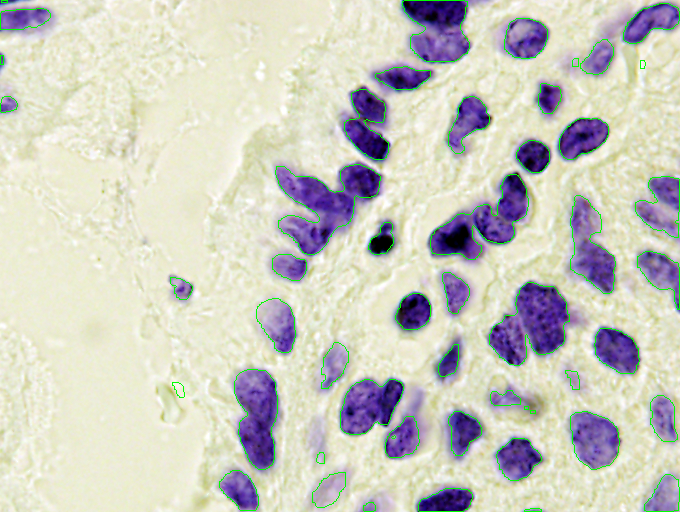

In [214]:
filename = 'a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f'
filename = 'a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d'
filename = '44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078'
#filename = '472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71'

dst = show_prediction(filename)
dst

(256, 256, 3)
(256, 256)


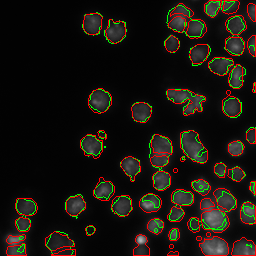

In [212]:
filename = "f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1"
filename = "fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de"
#filename = "2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707"
filename = "0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426"
dst = show_prediction(filename, test=False)
dst

(256, 256, 3)
(256, 256)


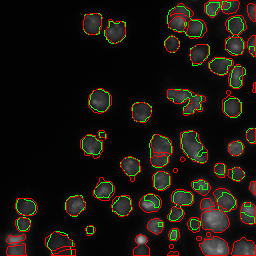

In [213]:
dst = show_prediction(filename, test=False, iterations=1)
dst